In [2]:
import pandas as pd
import numpy
import pickle
import time
import joblib
import gensim
import matplotlib.pyplot as plt

from itertools import islice
from scipy.linalg import block_diag
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel

In [3]:
# Remove warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Function to compute the corpus and dictionary for the DTM LDA
def createLDAvars(docs):

    # Create the variables needed for LDA from df[final_frqwds_removed]: dictionary (id2word), corpus
    
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(docs)

    #Filter words to only those found in at least a set number of documents (min_appearances)
    id2word.filter_extremes(no_below=20, no_above=0.6)
    
    # filter out stop words - "use" already filtered out by previous line
    id2word.filter_tokens(bad_ids=[id2word.token2id['research'], id2word.token2id['project']])

    # Create Corpus (Term Document Frequency)

    #Creates a count for each unique word appearing in the document, where the word_id is substituted for the word
    # corpus not need for c_v coherence
    corpus = [id2word.doc2bow(doc) for doc in docs]

    return id2word, corpus


# Modify the pre-processing function
def preprocess(df, stopwords):
    # Append all the final tokens
    text = []
    docs = df['final_tokens']
    
    for abstract in docs:
        text.append(' '.join(abstract))
        
    # Create the term-document matrix
    tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=0, lowercase=False, stop_words=stop_wds)
    tf_idf = tfidf_vectorizer.fit_transform(text)
            
    return (tf_idf, tfidf_vectorizer)


# function modified from https://nlpforhackers.io/topic-modeling/
def list_topics(topic_term_dist, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.  
    topic_words = []
    
    for idx, topic in enumerate(topic_term_dist):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1: 
            # check if the vectorized has an attribute get_features_names. if not vectorized contains terms hasattr('abc', 'lower')
            if hasattr(vectorizer, 'get_feature_names'):
                topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
            else:
                topic_words.append([vectorizer[i] for i in topic.argsort()[::-1]])
        else:
            if hasattr(vectorizer, 'get_feature_names'):
                topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
            else:
                topic_words.append([vectorizer[i] for i in topic.argsort()[:-top_n - 1:-1]])
        
    return topic_words



# function adapted from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
def nmf_models(doc_term_matrix, n_topics, vectorizer, rand_start):
    """
    Compute NMF model, save topics list for coherence calc
    Parameters:
    ----------
    tf_idf
    n_topics : list of number of topics
    """
    
    nmf_time = []
    topics_list = []
    W_list = []
    H_list = []
    
    i = rand_start
    for num_topics in n_topics:

        # create model
        t1 = time.time()
        nmf_model = NMF(n_components=num_topics, random_state = i)
        nmf_model.fit_transform(doc_term_matrix)
        t2 = time.time()
        nmf_time.append(t2-t1)
        #print(f"  Model time: {t2-t1}", flush=True)
        
        # create list of topics
        topics = list_topics(nmf_model.components_, vectorizer, top_n=10)
        topics_list.append(topics)
        
        # output completion message
        i = i+1
        #print('Number of topics =', num_topics, "complete.", flush=True)
        
        # save the matrix W and H
        W = nmf_model.fit_transform(doc_term_matrix)
        W_list.append(W)
        H = nmf_model.components_
        
        # truncate the H matrix: set the weight of the non top n words to zero
        #top_n = 10
        #for idx, topic in enumerate(H):
        #    thresold = numpy.nanmin(topic[topic.argsort()[:-top_n-1:-1]])
        #    topic[topic<thresold]=0  
        H_list.append(H)

    return nmf_time, topics_list, W_list, H_list


# solve an nmf model for each windows topic
def first_stage(path, year, n_topics, dictionary, docs):
    """
    Solve a dynamic nmf for each fiscal year
    Parameters:
    ----------
    path : location of term-document matrix
    year : list of fiscal year
    n_topics : list of number of topics
    dictionary : dictionary of terms
    docs : corpus
    """
    batch = 7
    
    windows_coherence = []
    windows_topic_list = []
    windows_topic = []
    windows_W = []
    windows_H = []
    windows_terms = []
    
    # Run the dynamic nmf for each fiscal year
    for y in year:
        # Load the document-term matrix
        (tf_idf,tfidf_vectorizer,df) = joblib.load( path+str(y)+'.pkl' )
    
        # Solve an nmf model for a given range of topics
        (nmf_time,topics_list,W_list,H_list) = nmf_models(doc_term_matrix=tf_idf, n_topics=n_topics, vectorizer=tfidf_vectorizer, rand_start = (batch)*len(n_topics))
        
        # Compute the coherence for each topics
        coherence = []
    
        for t in range(0,len(n_topics)):
            window_term_rankings = topics_list[t]
            cm = CoherenceModel(topics=window_term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', topn=10, processes=30)
            coherence.append(cm.get_coherence())
    
        # find the topics that maximize the coherence
        max_coherence = numpy.nanmax(coherence)
        index = coherence.index(max_coherence)
        topic_select = n_topics[index]
        fy_topic_list = topics_list[index]
        W = W_list[index]
        H = H_list[index]
       
        # For the best model (that maximize the coherence) transform the matrix H (for each topic set the weigth of non top n terms to 0)
        # select all the unique terms of topics
        topic_terms = list(set(sum(fy_topic_list,[])))
        
        # select the index of terms that appear in the topics and subset the matrix H to those terms
        indcol = [terms.index(i) for i in topic_terms]
        subH = H[:,indcol]
        
        # For each topic (rows) set the weigth of terms that are not listed the topic to 0.
        for i,j in enumerate(subH):
            # by row find the index of top_n terms
            indtopic = [topic_terms.index(p) for p in fy_topic_list[i]]
            notop = [k for k in range(len(topic_terms)) if k not in indtopic]
            j[notop]=0

         # append the result
        windows_coherence.append(max_coherence)
        windows_topic_list.append(fy_topic_list)
        windows_topic.append(topic_select)
        windows_W.append(W)
        windows_H.append(subH)
        windows_terms.append(topic_terms)
        print('--- windows topic '+str(y)+' solve ---')
        
    print('--- Dynamic nmf: first stage clear ---')
        
    return windows_topic, windows_coherence, windows_topic_list, windows_W, windows_H, windows_terms


# Create a new document term matrix based on topic
def create_matrix(windows_H, windows_terms):
    """
    Create the topic-term matrix from all window topics that have been added so far.
    """
    # Set a list of all terms unique terms across windows (all_terms) and the combine windows terms (all_windows_terms)
    all_windows_terms = sum(windows_terms,[])
    
    # Create a block diagonal matrix of all topics: the number of rows is the same as the length of list_terms
    M = block_diag(*windows_H)
    
    # Identify duplicated terms (columns) and sum them
    # The fastest way is to transform M into data frame with
    dfM = pd.DataFrame(data = M, columns=all_windows_terms).groupby(level=0, axis=1).sum()
    
    # Transform back the dataframe to matrix and get the variable names (in the order in the matrix) as the final all terms
    M_concat = dfM.to_numpy()
    all_terms = list(dfM.columns)
    
    
    print('--- New document-terms have been created ---')
    
    return M_concat, all_terms




# solve an nmf model for each windows topic
def second_stage(path, windows_H, windows_terms, n_topics, dictionary, docs):
    """
    Build a new document term matrix and run a new nmf model
    Parameters:
    ----------
    path : location of term-document matrix
    n_topics : list of number of topics
    dictionary : dictionary of terms
    docs : corpus
    """
    batch = 7
    
    # Build the new document-term matrix
    (M, all_terms) = create_matrix(windows_H, windows_terms)
    
    # Run a second nmf model
    (nmf_time,topics_list,W_list,H_list) = nmf_models(doc_term_matrix=M, n_topics=n_topics, vectorizer=all_terms, rand_start = (batch)*len(n_topics))
    
    print('--- Dynamic nmf: second stage clear ---')
    
    return M, all_terms, topics_list, W, H


# solve an nmf model for each windows topic
def track_dynamic(topic,W,windows_topic_list):
    """
    Link topics in the first stage with topic in second stage using the matrix W
    Parameters:
    ----------

    """
    # For each topic from the first stage (rows) find the topic in the second stage (columns) with the higher weight
    topic_second = []
    for i, topic_first in enumerate(W):
        topic_second.append(topic_first.argmax())
        
    # Split topics classification in the first by year
    it = iter(topic_second)
    topic_first_year = [[next(it) for _ in range(size)] for size in windows_topic]
    
    # For each topic, identify the correspondance for each year
    dynamic_topic_list = []
    for y in range(0, len(year)):
        topic_year = [i for i, e in enumerate(topic_first_year[y]) if e == topic]
        dynamic_topic_list.append(topic_year)

    # Compute the list of list of topics (list of year and list of main topic)
    dynamic_topic = []
    for y in range(0, len(year)):
        dynamic_list = dynamic_topic_list[y]
        fy_topic = [windows_topic_list[y][dynamic_list[i]] for i in range(0,len(dynamic_list))] 
        dynamic_topic.append(fy_topic)
        
    # Print the result in a dataframe
    topic_print = []
    names = []

    # print the dynamic topic
    for y in range(0,len(year)):
        for t in range(0,len(dynamic_topic[y])):
            topic_print.append(dynamic_topic[y][t])
            names.append('Year_'+str(year[y])+'_'+str(t))
        
    df = pd.DataFrame (topic_print).transpose()
    df.columns = names
    
    return df, dynamic_topic_list


In [5]:
# Load the dataset. Apply the DTM on the coronavirus corpus (1000 abstracts)
f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/case_studies/coronavirus_corpus.pkl', 'rb')
df = pickle.load(f)
f.close()
df.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,...,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
5122,5122,5608,95622,Host - virus interactions are greatly affected...,2008,Affect; Antiviral Agents; Area; Biochemical; D...,THE ROLE OF A HOST ION PUMP IN RNA VIRUS RECOM...,NSF,NSF,NaN,...,UNITED STATES,NaN,NaN,47.074,2008,612000.0,NaN,1,1,"[host, virus, interaction, greatly, affect, ex..."
13938,13938,15726,152221,AbstractThe American Society for Virology (ASV...,2008,abstracting; Acquired Immunodeficiency Syndrom...,"INTERNATIONAL CONGRESS OF VIROLOGY, ISTANBUL, ...",HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2009,93.855,2008,30000.0,NaN,1,1,"[american, society, virology_asv, wish, provid..."
14418,14418,17118,153617,DESCRIPTION (provided by applicant): Severe a...,2008,Abbreviations; Address; Alleles; Alphavirus; A...,SARS REVERSE GENETICS,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,271608.0,NaN,1,1,"[severe, acute, respiratory, syndrome, life_th..."
14514,14514,17384,153888,DESCRIPTION (provided by applicant): Human cor...,2008,Acute; Age-Years; Antigens; Archives; base; Bi...,EPIDEMIOLOGY AND CLINICAL FEATURES OF HUMAN CO...,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,75292.0,NaN,1,1,"[human, coronaviruse_hcov, initially, identify..."
14565,14565,17526,154033,"DESCRIPTION: Plus-stranded RNA viruses, which ...",2008,Affect; Agriculture; Animals; Antiviral Agents...,ROLES OF HOST RNA BINDING PROTEINS IN VIRUS RE...,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,200124.0,NaN,1,1,"[strand, rna, virus, pose, significant, risk, ..."


In [6]:
# Preprocessing

# Create a list of tokens 
df["list_final_tokens"] = df["final_tokens"].str.split(' ').tolist()


year = df['FY'].unique()

for y in year:
    df_subset = df[df['FY']==y]
    
    # save the pickle file
    pickle.dump(df_subset, open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/data/Coronavirus_'+str(y)+'.pkl','wb'))


# Create the term-document matrix tfidf for each pkl file
stop_wds = ['research', 'study', 'project']  # use will be eliminated by max_df

for y in year:
    # Load the sample for a given year
    fw = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/data/Coronavirus_'+str(y)+'.pkl', 'rb')
    dfw = pickle.load(fw)
    fw.close()
            
    # Pre-processing the pkl file
    (tf_idf, tfidf_vectorizer) = preprocess(dfw, stop_wds)
    
    # Save the term-document matrix
    joblib.dump((tf_idf,tfidf_vectorizer,df), '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/Term_docs_'+str(y)+'.pkl' )
    
# build the dictionary id2word
docs = df["final_tokens"]
[dictionary, corpus] = createLDAvars(docs)

In [7]:
# First stage 
path = '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/NMF/Term_docs_'
n_topics = list(range(10,41,5))

(windows_topic, windows_coherence, windows_topic_list, windows_W, windows_H, windows_terms) = first_stage(path, year, n_topics, dictionary, docs)

--- windows topic 2008 solve ---
--- windows topic 2009 solve ---
--- windows topic 2010 solve ---
--- windows topic 2011 solve ---
--- windows topic 2012 solve ---
--- windows topic 2013 solve ---
--- windows topic 2014 solve ---
--- windows topic 2015 solve ---
--- windows topic 2016 solve ---
--- windows topic 2017 solve ---
--- windows topic 2018 solve ---
--- windows topic 2019 solve ---
--- Dynamic nmf: first stage clear ---


In [8]:
# print the best number of topic for each windows
windows_topic

[35, 15, 25, 10, 20, 10, 20, 10, 15, 10, 10, 15]

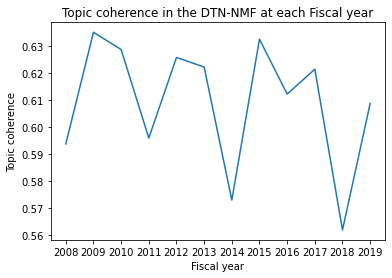

In [9]:
# Print the coherence at the first stage
coherence_windows_ts = pd.Series(windows_coherence, index =year)
plt.plot(coherence_windows_ts)
plt.title('Topic coherence in the DTN-NMF at each Fiscal year')
plt.xlabel("Fiscal year")
plt.ylabel("Topic coherence")
plt.savefig('Coherence_first_stage.png')

In [10]:
# Solve for the second stage
(M, all_terms, topics_list, W_list, H_list) = second_stage(path, windows_H, windows_terms, n_topics, dictionary, docs)

--- New document-terms have been created ---
--- Dynamic nmf: second stage clear ---


NameError: name 'W' is not defined

In [ ]:
# Compute the coherence for the second stage
coherence = []
    
for t in range(0,len(n_topics)):
    window_term_rankings = topics_list[t]
    cm = CoherenceModel(topics=window_term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', topn=10, processes=30)
    coherence.append(cm.get_coherence())

In [ ]:
# Plot the coherence
coherence_ts = pd.Series(coherence, index =n_topics)
plt.plot(coherence_ts)
plt.title('Topic coherence in the DTN-NMF from the 2nd stage')
plt.xlabel("Number of topic")
plt.ylabel("Coherence")
plt.savefig('Coherence_second_stage.png')

In [ ]:
# find the best topic at the second stage: topic that maximize the coherence
max_coherence = numpy.nanmax(coherence)
index = coherence.index(max_coherence)
topic_select = n_topics[index]
topic_list = topics_list[index]
W = W_list[index]
H = H_list[index]
print('The best topic based on coherence is topic: '+str(topic_select))

In [ ]:
# Print the list of topics
for i in range(0,len(topic_list)):
    print(topic_list[i])

In [ ]:
# Select a topic and observw the dynamic
topic = 5
(df,assign) = track_dynamic(topic,W,windows_topic_list)
df

In [ ]:
assign

In [ ]:
# Track the change in topic dynamic

In [ ]:
# Compute the topic prevalence